In [1]:
!pip install keras-tcn --no-dependencies

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip "/content/drive/My Drive/TESS_data/processed_curves_mwebv_trigger.zip" -d "processed_curves"

Archive:  /content/drive/My Drive/TESS_data/processed_curves_mwebv_trigger.zip
  inflating: processed_curves/lc_2018eel_processed.csv  
  inflating: processed_curves/lc_2018emt_processed.csv  
  inflating: processed_curves/lc_2018eny_processed.csv  
  inflating: processed_curves/lc_2018eoa_processed.csv  
  inflating: processed_curves/lc_2018eoc_processed.csv  
  inflating: processed_curves/lc_2018eod_processed.csv  
  inflating: processed_curves/lc_2018eph_processed.csv  
  inflating: processed_curves/lc_2018eqo_processed.csv  
  inflating: processed_curves/lc_2018esp_processed.csv  
  inflating: processed_curves/lc_2018esw_processed.csv  
  inflating: processed_curves/lc_2018evo_processed.csv  
  inflating: processed_curves/lc_2018exc_processed.csv  
  inflating: processed_curves/lc_2018fdw_processed.csv  
  inflating: processed_curves/lc_2018fdx_processed.csv  
  inflating: processed_curves/lc_2018fgb_processed.csv  
  inflating: processed_curves/lc_2018fhs_processed.csv  
  inflati

In [4]:
from tensorflow import keras
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


data_dir = "/content/processed_curves/"
files = os.listdir(data_dir)
timesteps = 60
cols = ["cts", "e_cts", "mwebv", "TJD_discovery_rel"]
targets = ["relative_time", "e_cts"]
n_features = len(cols)
test_size = int(0.8 * len(files))

def find_max_light(curve):
    id_max = curve[curve["cts"] != 0]['cts'].idxmax()
    max_data = curve.loc[id_max, :]
    max_data['relative_time'] = id_max
    return max_data

if tf.test.gpu_device_name() != '/device:GPU:0':
    print('WARNING: GPU device not found.')
else:
    print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

def format_data(data):
    # x = []
    # y = []
    x = np.zeros(shape=(len(data), 60, n_features))
    y = np.zeros(shape=(len(data), len(targets)))

    for i, csv in enumerate(data):
        df_x = pd.read_csv(data_dir + csv, usecols=cols+['relative_time'], index_col="relative_time")
        max_light = find_max_light(df_x)
        for t in range(df_x.index.size, timesteps):
            if not t in df_x.index:
                df_x.loc[t] = np.zeros(shape=4)

        x[i] = df_x.to_numpy()
        y[i] = max_light[targets].to_numpy()

    #reshapes data to be (num_samples, timesteps, num_features), instead of (num_samples, timesteps)
    def add_feature_dim(input):
        return input.reshape(input.shape[0], input.shape[1], n_features)
    
    def split_train_test(arr):
      return arr[:test_size], arr[test_size:]

    x_train, x_test = split_train_test(x)
    y_train, y_test = split_train_test(y)
    
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = format_data(files)
# [num_samples, timesteps, num_features)
print(f"input shapes, training:{x_train.shape}")
# [num samples,]
print(f"output shapes, training:{y_train.shape}")

SUCCESS: Found GPU: /device:GPU:0
input shapes, training:(2494, 60, 4)
output shapes, training:(2494, 2)


In [5]:
# col = "TJD_discovery_rel"
# max_lights = []
# means = []

# for csv in files:
#     df_x = pd.read_csv(data_dir + csv, index_col="relative_time")
#     max_time, max_light = find_max_light(df_x)

#     max_lights.append(max_light[col])
#     means.append(df_x[col].mean())

# max_lights = pd.DataFrame(max_lights, index=files, columns=[col])
# original_means = pd.DataFrame(means, index=files, columns=[col])
# original_means.sort_values(col)

In [7]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import GRU
import tensorflow_probability as tfp
from tcn import TCN
tfd = tfp.distributions

def negloglik_with_uncert(y_true, y_pred):                   
  mu = y_pred.loc
  sigma = y_pred.scale
  y_true_mu = y_true[:,  0:1]
  y_true_sigma = y_true[:, 1:2]

  variance = tf.square(sigma)  + tf.square(y_true_sigma)
  mse = -0.5 * tf.square(y_true_mu - mu) / variance
  log_term = -0.5 * tf.math.log(2*np.pi*variance)
  loglikelihood = mse + log_term
  return -loglikelihood

def build_model(model_type, dropout_rate=0.2, learning_rate=0.001, mc_dropout=False, variational=False):
  input = keras.Input(shape=(timesteps, n_features))
  masked_input = keras.layers.Masking(mask_value=0., input_shape=(timesteps, n_features))(input)

  if model_type == "LSTM":
      hidden = LSTM(50, activation='relu', return_sequences=True)(masked_input)
      hidden = Dropout(dropout_rate)(hidden, training=mc_dropout)
      hidden = BatchNormalization()(hidden)
      hidden = LSTM(50, activation='relu')(hidden)
      hidden = Dropout(dropout_rate)(hidden, training=mc_dropout)
      hidden = BatchNormalization()(hidden)
      
  if model_type == "TCN":
      hidden = TCN(100, kernel_size=2, nb_stacks=1, dilations=[1, 2, 4, 8],
              padding='causal', use_skip_connections=True, dropout_rate=dropout_rate, activation='relu')(masked_input, training=mc_dropout)

  if model_type == "GRU":
      hidden = GRU(50, activation='relu', return_sequences=True)(masked_input)
      hidden = Dropout(dropout_rate)(hidden, training=mc_dropout)
      hidden = BatchNormalization()(hidden)
      hidden = GRU(50, activation='relu')(hidden)
      hidden = Dropout(dropout_rate)(hidden, training=mc_dropout)
      hidden = BatchNormalization()(hidden)

  hidden = Dropout(dropout_rate)(hidden, training=mc_dropout)
  hidden = Dense(2)(hidden)
  output = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[..., :1], scale=1e-5 + tf.math.softplus(0.05 * t[...,1:])))(hidden)
  model = keras.Model(inputs=input, outputs=output)
  # opt = keras.optimizers.Adam(learning_rate=learning_rate, clipvalue=1.0)
  opt = keras.optimizers.Adam(learning_rate=learning_rate)
  model.compile(optimizer=opt, loss=negloglik_with_uncert)
  return model

model = build_model("GRU", mc_dropout=True)


In [8]:
import datetime

timestamp =  datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + timestamp
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# fit model
history = model.fit(x_train, y_train, epochs=200, batch_size=32, callbacks=[tensorboard_callback])

Epoch 1/200
78/78 [==============================] - 31s 309ms/step - loss: 1091.0229
Epoch 2/200
78/78 [==============================] - 24s 306ms/step - loss: 988.0640
Epoch 3/200
78/78 [==============================] - 22s 277ms/step - loss: 850.3809
Epoch 4/200
78/78 [==============================] - 22s 282ms/step - loss: 670.6207
Epoch 5/200
78/78 [==============================] - 22s 277ms/step - loss: 485.6506
Epoch 6/200
78/78 [==============================] - 22s 281ms/step - loss: 343.1882
Epoch 7/200
78/78 [==============================] - 22s 284ms/step - loss: 238.2402
Epoch 8/200
78/78 [==============================] - 22s 280ms/step - loss: 173.1077
Epoch 9/200
78/78 [==============================] - 22s 278ms/step - loss: 126.9720
Epoch 10/200
78/78 [==============================] - 24s 306ms/step - loss: 100.0724
Epoch 11/200
78/78 [==============================] - 22s 278ms/step - loss: 79.4186
Epoch 12/200
78/78 [==============================] - 22s 282ms

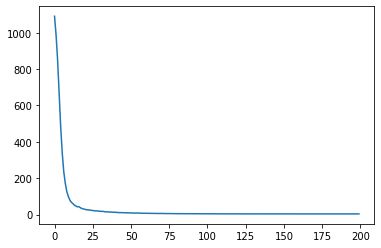

In [9]:
#save model 
model.save(f"/content/drive/My Drive/TESS_models/{timestamp}.h5")

#plot model
plt.plot(history.history['loss'])

In [11]:
import tensorflow as tf
import pandas as pd
import tensorflow_probability as tfp
import time

time_id = f"{timestamp}.h5"
time_id = "lstm mc dropout.h5"
iterations = 1
custom_objects = {"DistributionLambda": tfp.layers.DistributionLambda, "TCN": TCN}

def predict(model, test, iterations=100):
  test_len = test.shape[0]
  avg_t = np.zeros((test_len,1))
  avg_uncert = np.zeros((test_len,1))
  for i in range(iterations):
    distrib = model(test)
    max_t = distrib.mean().numpy()
    uncert = distrib.stddev().numpy()
    avg_t += max_t
    avg_uncert += uncert
  avg_t = avg_t.reshape(avg_t.shape[0])
  avg_uncert = avg_uncert.reshape(avg_uncert.shape[0])
  avg_t /= iterations
  avg_uncert /= iterations
  return avg_t, avg_uncert

def display_predictions(max_t, uncert):
  predictions = pd.DataFrame({"max_t": max_t, "uncert": uncert})
  predictions['squared_error'] = np.square(y_test[:, 0] - predictions['max_t'])
  print(f'MSE: {predictions["squared_error"].mean()}')
  print(f'avg uncert: {predictions["uncert"].mean()}')
  display(predictions)

def predict_real_time(real, model, test, iterations=100):
  uncert_axis = []
  mse_axis = []
  max_t_axis = []
  for i in range(1, timesteps+1):
    input_i = test.copy()
    input_i[:, i:, :] = 0.0
    max_t, uncert = predict(model, input_i, iterations)
    uncert_axis.append(uncert.mean())
    squared_error = np.square(real-max_t)
    mse_axis.append(squared_error.mean())
  return pd.DataFrame({"timesteps": range(1, timesteps+1), "mse": mse_axis, "avg_uncert":uncert_axis})

def plot_metrics():
  with keras.utils.custom_object_scope(custom_objects):
    loaded_model = keras.models.load_model("drive/My Drive/TESS_models/"+time_id, compile = False)
    t, uncert = predict(loaded_model, x_test)
    display_predictions(t, uncert)
    # df = predict_real_time(y_test[:, 0], loaded_model, x_test, 10)
    # df.plot(x="timesteps", y="mse")
    # df.plot(x="timesteps", y="avg_uncert")
    # display(df)

plot_metrics()

MSE: 215.1012776057931
avg uncert: 14.988953818380832


,max_t,uncert,squared_error
0,35.770236,17.379352,1.512319
1,25.975477,15.337645,674.725400
2,26.759347,14.831957,52.427062
3,36.780161,13.156220,27.246718
4,32.624767,14.183760,54.394061
...,...,...,...
619,32.567894,13.696167,238.149886
620,26.433282,15.360333,503.252150
621,25.094443,15.227184,47.686714
622,26.615886,15.292413,11.452226
